In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from skimage.feature import hog
from skimage.feature import corner_harris, corner_peaks
from skimage.filters import sobel
from skimage import io, img_as_ubyte
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

In [ ]:
# Load MNIST dataset from Kaggle
train_data = pd.read_csv("mnist_train.csv")
test_data = pd.read_csv("mnist_test.csv")

# Split into X and y
X_train = train_data.iloc[:, 1:].values
y_train = train_data.iloc[:, 0].values
X_test = test_data.iloc[:, 1:].values
y_test = test_data.iloc[:, 0].values

# Reshape and normalize
X_train = X_train.reshape(-1, 28, 28, 1) / 255.0
X_test = X_test.reshape(-1, 28, 28, 1) / 255.0

# Resize images (if needed)
X_train_resized = np.array([cv2.resize(img, (32, 32)) for img in X_train])
X_test_resized = np.array([cv2.resize(img, (32, 32)) for img in X_test])

In [ ]:
def extract_features(images, hog_size=144, max_corners=50):
    features = []

    for img in images:
        # HOG features (ensure fixed size by resizing image if needed)
        fd, hog_image = hog(img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
        if len(fd) > hog_size:
            fd = fd[:hog_size]  # Trim if too large
        elif len(fd) < hog_size:
            fd = np.pad(fd, (0, hog_size - len(fd)))  # Pad if too small

        # Edge Detection (Sobel)
        edge_sobel = sobel(img)
        edge_sobel_flat = edge_sobel.ravel()[:hog_size]  # Ensure same size as HOG features

        # Corner Detection (fixed size, max_corners)
        corners = corner_peaks(corner_harris(img), min_distance=5)[:max_corners]
        corners_flat = corners.flatten()
        if len(corners_flat) < max_corners * 2:  # Each corner has 2 coordinates
            corners_flat = np.pad(corners_flat, (0, max_corners * 2 - len(corners_flat)))

        # Texture Features (LBP as a single scalar)
        lbp = cv2.Laplacian(img_as_ubyte(img), cv2.CV_64F).var()

        # Combine all features (make sure they are the same size)
        combined_features = np.hstack([fd, edge_sobel_flat, corners_flat, [lbp]])
        features.append(combined_features)

    return np.array(features)

In [ ]:

X_train_features = extract_features(X_train_resized)
X_test_features = extract_features(X_test_resized)

# Standardize features
scaler = StandardScaler()
X_train_features = scaler.fit_transform(X_train_features)
X_test_features = scaler.transform(X_test_features)


In [ ]:



# CNN Model
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_resized, y_train, validation_data=(X_test_resized, y_test), epochs=10, batch_size=64)





/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 78s 82ms/step - accuracy: 0.8999 - loss: 0.3347 - val_accuracy: 0.9844 - val_loss: 0.0471
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 83s 83ms/step - accuracy: 0.9861 - loss: 0.0459 - val_accuracy: 0.9850 - val_loss: 0.0421
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 79s 79ms/step - accuracy: 0.9901 - loss: 0.0312 - val_accuracy: 0.9904 - val_loss: 0.0280
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 84s 81ms/step - accuracy: 0.9931 - loss: 0.0216 - val_accuracy: 0.9915 - val_loss: 0.0256
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 80s 79ms/step - accuracy: 0.9942 - loss: 0.0177 - val_accuracy: 0.9870 - val_loss: 0.0444
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 83s 80ms/step - accuracy: 0.9948 - loss: 0.0148 - val_accuracy: 0.9876 - val_loss: 0.0434
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 86s 84ms/step - accuracy: 0.9970 - loss: 0.0084 - val_accuracy: 0.9905 - val_loss: 0.0346
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 77s 79ms/step - accuracy: 0.9981 - loss: 0.0069 - 

In [ ]:
# Evaluation
y_pred = np.argmax(model.predict(X_test_resized), axis=1)

# Accuracy and Confusion Matrix
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step
Accuracy: 0.9901
Confusion Matrix:
 [[ 977    0    1    0    0    0    0    1    1    0]
 [   1 1126    1    1    0    1    1    0    4    0]
 [   0    1 1021    0    0    0    1    7    2    0]
 [   0    0    2 1003    0    5    0    0    0    0]
 [   0    0    1    0  974    0    0    0    1    6]
 [   0    1    0    5    0  884    1    0    1    0]
 [   5    2    1    0    4    6  937    0    3    0]
 [   0    2    4    1    0    1    0 1016    1    3]
 [   2    0    2    0    0    0    0    0  968    2]
 [   0    0    0    2    2    4    0    1    5  995]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.99      0.99      0.99      1032
           3       0.99      0.99      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.98      0.99      0.9

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt


313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step
Accuracy: 0.9901
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.99      0.99      0.99      1032
           3       0.99      0.99      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.98      0.99      0.99       892
           6       1.00      0.98      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.98      0.99      0.99       974
           9       0.99      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



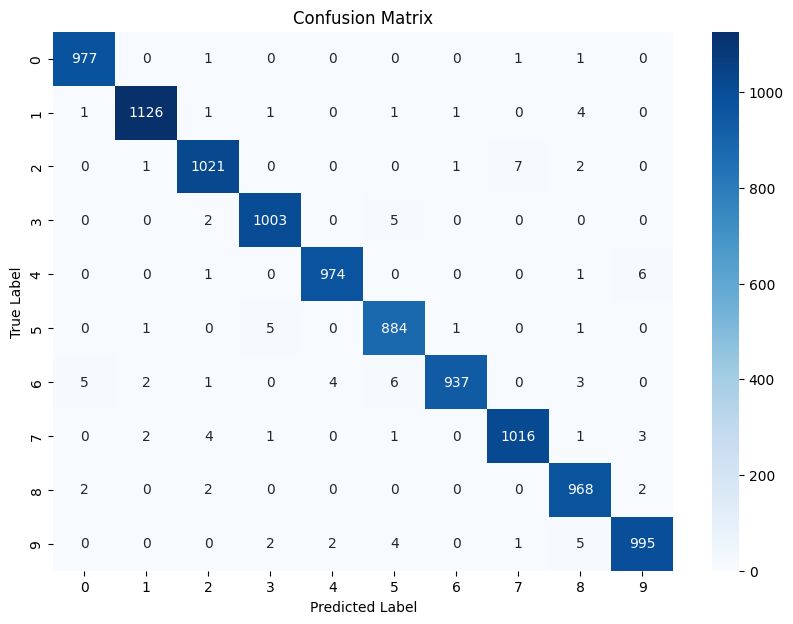

In [ ]:
# Make predictions
y_pred = np.argmax(model.predict(X_test_resized), axis=1)

# Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Classification Report
class_report = classification_report(y_test, y_pred, target_names=[str(i) for i in range(10)])
print("Classification Report:\n", class_report)

# Visualize the Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[str(i) for i in range(10)], yticklabels=[str(i) for i in range(10)])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


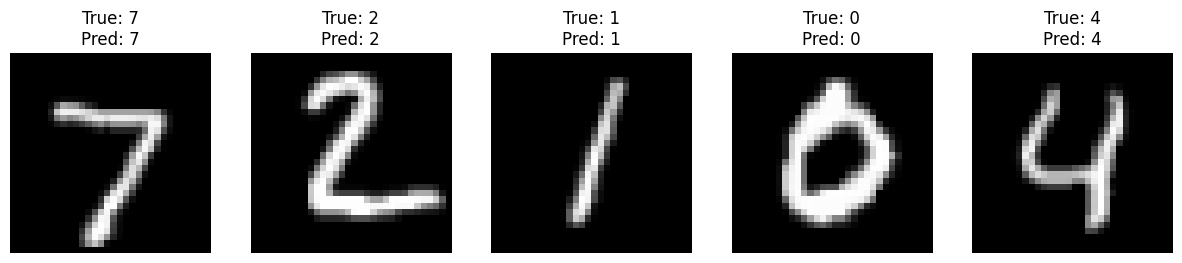

In [ ]:

# Plot sample predictions
def plot_sample_predictions(X, y_true, y_pred, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 15))
    for i in range(num_samples):
        axes[i].imshow(X[i].reshape(32, 32), cmap='gray')
        axes[i].set_title(f"True: {y_true[i]}\nPred: {y_pred[i]}")
        axes[i].axis('off')
    plt.show()

plot_sample_predictions(X_test_resized, y_test, y_pred)